In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 120.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.

In [125]:
from PIL import Image
import torch
import numpy as np
import cv2
from facenet_pytorch import MTCNN
import matplotlib.pyplot as plt

# Инициализация детектора
mtcnn = MTCNN(keep_all=True, device='cuda' if torch.cuda.is_available() else 'cpu')

def pad_to_square(box, image_shape):
    """
    Получает квадратный bbox с паддингом.
    """
    x1, y1, x2, y2 = box
    w = x2 - x1
    h = y2 - y1

    w = 1.3*w
    h = 1.3*h

    max_side = max(w, h)

    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2

    new_x1 = int(max(cx - max_side / 2, 0))
    new_y1 = int(max(cy - max_side / 2, 0))
    new_x2 = int(min(cx + max_side / 2, image_shape[1]))
    new_y2 = int(min(cy + max_side / 2, image_shape[0]))

    return [new_x1, new_y1, new_x2, new_y2]

def detect_and_align_faces(image_path, output_size=256):
    """
    Основной пайплайн
    """
    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img)

    # Детекция
    boxes, _ = mtcnn.detect(img)
    if boxes is None:
        print("Лица не найдены.")
        return []

    aligned_faces = []
    for box in boxes:
        box = [int(coord) for coord in box]
        square_box = pad_to_square(box, img_np.shape)

        x1, y1, x2, y2 = square_box
        face = img_np[y1:y2, x1:x2]

        face = cv2.resize(face, (output_size, output_size))
        aligned_faces.append(Image.fromarray(face))

    return aligned_faces

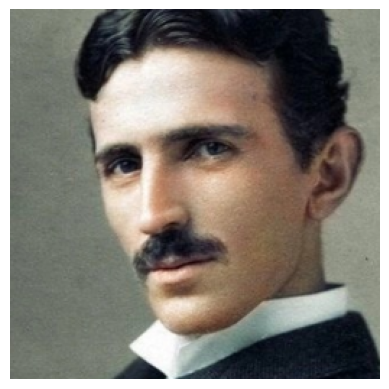

In [126]:
import matplotlib.pyplot as plt
image_path = "resources/tesla1.jpg"
aligned_faces = detect_and_align_faces(image_path)
#aligned_faces = [Image.open(image_path)]
# Визуализируем
for i, face in enumerate(aligned_faces):
    plt.subplot(1, len(aligned_faces), i + 1)
    plt.imshow(face)
    plt.axis('off')
plt.show()

In [127]:
import sys
sys.path.append('/content/lib')

from torchvision import transforms
import torch
from shg import StackedHourglassNetwork as SHG
from utils import heatmaps_to_coords, rescale_coords
model = SHG(num_stacks=2, num_keypoints=5)
model.load_state_dict(torch.load('checkpoints/shg_e90_r46.pt', map_location=torch.device(device)))
model = model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # или 256x256, в зависимости от модели
    transforms.ToTensor(),          # [0, 255] -> [0.0, 1.0]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # → [-1, 1]
])
tensor_faces = torch.stack([transform(img) for img in aligned_faces])

preds = model(tensor_faces.to(device))[-1]
val_coords = heatmaps_to_coords(preds.to('cpu'))
val_rescaled_coords = rescale_coords(val_coords,(64,64),(256,256))


tensor([[ 1.8141e-02,  1.8460e-02,  1.7989e-02,  ..., -3.3222e-03,
         -1.2730e-02,  2.9527e-02],
        [-3.1434e-03, -1.8484e-03, -8.1588e-03,  ..., -1.8010e-02,
         -2.3153e-02, -1.6237e-02],
        [ 1.7345e-03, -2.4913e-05,  7.4970e-03,  ..., -7.4169e-04,
         -4.6910e-03,  1.2000e-03],
        ...,
        [ 4.8202e-03,  5.5720e-03,  3.5650e-03,  ...,  9.7682e-03,
          1.2038e-02,  1.9303e-03],
        [-2.6195e-03,  4.5955e-03,  8.8416e-03,  ...,  5.6999e-03,
          5.0157e-03, -1.3845e-02],
        [-7.1458e-03, -1.6468e-02,  4.1567e-05,  ...,  9.1578e-03,
         -1.2329e-02, -1.2228e-02]], grad_fn=<SelectBackward0>)


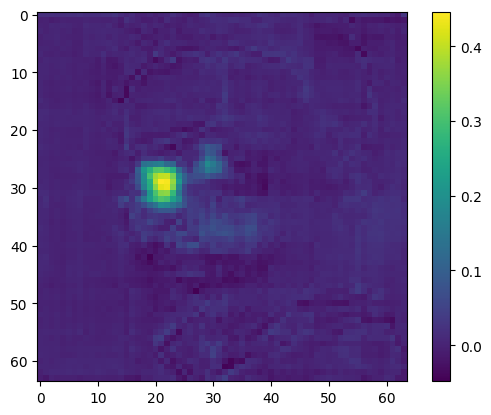

In [128]:
import matplotlib.pyplot as plt

print(preds[0, 0])
plt.imshow(preds[0, 0].detach().cpu())  # первый кейпоинт первой картинки
plt.colorbar()
plt.show()

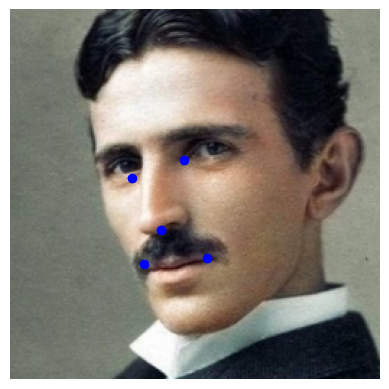

tensor([[[ 84., 116.],
         [120., 104.],
         [104., 152.],
         [ 92., 176.],
         [136., 172.]]])

In [129]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from PIL import Image

def denormalize(tensor, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    """Обратно нормализует тензор изображения [C, H, W]"""
    mean = torch.tensor(mean).view(-1, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(-1, 1, 1).to(tensor.device)
    return tensor * std + mean

def draw_image(img, landmarks, pred_landmarks=None):
    fig, ax = plt.subplots()
    ax.imshow(img)

    # Landmark точки
    for i in range(0, len(landmarks)):
        x = landmarks[i][0]
        y = landmarks[i][1]
        ax.plot(x, y, 'bo')  # синяя точка

    if not pred_landmarks is None:
        for i in range(0, len(pred_landmarks)):
            x = pred_landmarks[i][0]
            y = pred_landmarks[i][1]
            ax.plot(x, y, 'ro')  # красная точка


#    ax.set_title(f"Image: {img_id}")
    plt.axis('off')
    plt.show()

draw_image(denormalize(tensor_faces[0]).permute(1,2,0), val_rescaled_coords[0])
val_rescaled_coords

In [90]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet
        std=[0.229, 0.224, 0.225]
    )
])

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class EmbeddedBackbone(nn.Module):
    def __init__(self, backbone, num_classes, num_unfreeze = -1, emb_dim = 512):
        super().__init__()
        self.backbone = backbone
        self.embeddings_dim = emb_dim
        self.num_classes = num_classes
        in_features = backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.embeddings = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(in_features, self.embeddings_dim, bias=True),
            nn.BatchNorm1d(self.embeddings_dim),
        )

        self.classificator = nn.Linear(self.embeddings_dim, self.num_classes)

        if num_unfreeze >= 0 :
            for param in self.backbone.parameters():
                param.requires_grad = False

            if num_unfreeze > 0:
                resnet_blocks = [self.backbone.layer1, self.backbone.layer2, self.backbone.layer3, self.backbone.layer4]
                for block in resnet_blocks[-num_unfreeze:]:
                    for param in block.parameters():
                        param.requires_grad = True


    def forward(self, x):
        x = self.backbone(x)
        x = self.embeddings(x)
        x = self.classificator(x)
        return(x)

class ArcFaceLayer(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.3, easy_margin=False):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.s = s
        self.m = m
        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # input: (B, in_features)
        # label: (B,)
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))  # (B, C)
        sine = torch.sqrt(1.0 - torch.clamp(cosine**2, 0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1), 1.0)

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

    def forward_logits(self, x):
        x = F.normalize(x)
        W = F.normalize(self.weight, dim=1)
        return torch.matmul(x, W.T)  # чистый cos(θ), без margin

class FaceNetArc(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        num_classes = backbone.classificator.out_features
        self.backbone = backbone
        self.backbone.classificator = nn.Identity()  # отключаем стандартный классификатор

        self.arc_margin = ArcFaceLayer(512, num_classes)

    def forward(self, x, labels=None):
        x = self.backbone(x)            # (B, 512)

        if labels is not None:
            logits = self.arc_margin(x, labels)  # ArcFace logits
            return logits
        else:
            return F.normalize(x)       # Для инференса

    def forward_logits(self, x):
        return self.arc_margin.forward_logits(x)


In [98]:
import torchvision.models as models

model = EmbeddedBackbone(models.resnet18(pretrained=True),100, num_unfreeze = 2)
arcface_model = FaceNetArc(model).to(device)
arcface_model.load_state_dict(torch.load('checkpoints/arcface_r18_c100_70.pt', map_location=device))


<All keys matched successfully>

In [ ]:
import torch
import torch.nn.functional as F

def compute_cosine_distances(embeddings1: torch.Tensor, embeddings2: torch.Tensor) -> torch.Tensor:
    """
    Вычисляет косинусное расстояние между двумя наборами эмбеддингов.

    embeddings1: (N, D) — первый батч эмбеддингов
    embeddings2: (M, D) — второй батч эмбеддингов

    Возвращает: (N, M) матрицу расстояний
    """
    # Нормализуем эмбеддинги (ArcFace обучается на нормированных вектрах)
    embeddings1 = F.normalize(embeddings1, dim=1)
    embeddings2 = F.normalize(embeddings2, dim=1)

    # Косинусная близость → [N, M]
    cosine_similarity = embeddings1 @ embeddings2.T

    # Косинусное расстояние = 1 - косинусная близость
    cosine_distance = 1 - cosine_similarity

    return cosine_distance


In [131]:
faces = ["resources/janegoodall_1.jpg", "resources/janegoodall_2.jpg", "resources/janegoodall_3.jpg",
         "resources/janegoodall_4.jpg", "resources/tesla1.jpg"]

aligned_faces = [detect_and_align_faces(f)[0] for f in faces]

print(f"Num Faces: {len(aligned_faces)}")

#similar_faces_1 = detect_and_align_faces("resources/janegoodall_1.jpg")
#similar_faces_2 = detect_and_align_faces("resources/tesla1.jpg")

#similar_faces = [similar_faces_1[0], similar_faces_2[0]]

#for i, face in enumerate(aligned_faces):
#    plt.subplot(1, len(aligned_faces), i + 1)
#    plt.imshow(face)
#    plt.axis('off')
#plt.show()



Num Faces: 5


In [132]:
import torch.nn.functional as F

tensor_faces = torch.stack([transform(img) for img in aligned_faces])
arcface_model.eval()
embeddings = arcface_model(tensor_faces.to(device))
print(embeddings.shape)

torch.Size([5, 512])


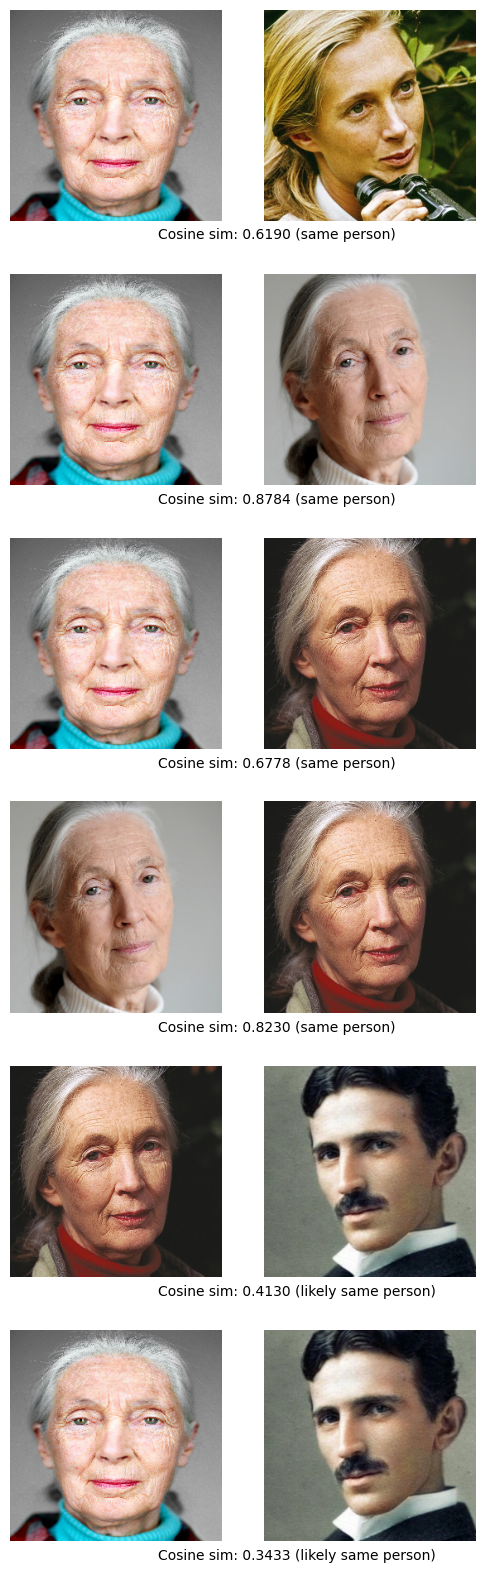

In [133]:
pairs = [[0,1],[0,2],[0,3],[2,3],[3,4],[0,4]]

fig, axs = plt.subplots(len(pairs), 2, figsize=(6, 20))
for i, (idx1, idx2) in enumerate(pairs):
    sim = F.cosine_similarity(embeddings[idx1].unsqueeze(0), embeddings[idx2].unsqueeze(0)).item()
    sim_text = 'different people'
    if sim > 0.6:
        sim_text = 'same person'
    elif sim > 0.3:
        sim_text = 'likely same person'


    axs[i, 0].imshow(aligned_faces[idx1])
    axs[i, 0].axis('off')

    axs[i, 1].imshow(aligned_faces[idx2])
    axs[i, 1].axis('off')
    axs[i, 1].text(
        -0.5, -0.1, f"Cosine sim: {sim:.4f} ({sim_text})",
        transform=axs[i, 1].transAxes,
        fontsize=10, ha='left', va='bottom'
    )


#dist = compute_cosine_distances(embeddings[0].unsqueeze(0), embeddings[1].unsqueeze(0))
#print(f"Cosine distance: {dist.item():.4f}")

plt.show()

